## COOKBOOK
### 1- Import of python modules

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.stats as scp
from math import *
from collections import OrderedDict
import scipy.optimize as optimizer

from utils import *
from portfolio_stats import *
from portfolio_opt import mean_variance_opt as mvo
#import yfinance as yf

%matplotlib inline

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


import cufflinks as cf

# Make plotly work in jupyter notebook... In case of using juoyter lab, you will maybe need to install the plotly extension
# By using this command 'jupyter labextension install jupyterlab-plotly', you will get the extension you need to make plotly work 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# In order to use plotly offline
cf.go_offline()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2- Data import & cleaning

This cookbook is mainly aimed at trying to test the python code and modules. The list of ETF tickers is purposely chosen and tries to reproduce my current holdings in December 2020.  
  - LQQ : Lyxor Nasdaq-100 Daily (2x) Leveraged UCITS ETF Acc --
  - HLT : Lyxor Index Fund - Lyxor Stoxx Europe 600 Healthcare UCITS ETF Acc -- 
  - FOO : Lyxor Index Fund - Lyxor Stoxx Europe 600 Food & Beverage UCITS ETF Acc --
  - MVAU : Lyxor FTSE USA Minimum Variance UCITS ETF --
  - AWAT : Lyxor PEA Eau (World Water) UCITS ETF Capi --
  
Data are sourced from https://www.lyxoretf.fr/

#### Cleaning and converting daily data to weekly data...

In [2]:
paths = ['Data/NAV_lqq.csv', 'Data/NAV_awat.csv', 'Data/NAV_foo.csv', 'Data/NAV_hlt.csv', 'Data/NAV_mvau.csv']
tickers = ['lqq', 'awat', 'foo', 'hlt', 'mvau']
portfolio_raw_data = import_data(paths, tickers)
portfolio_raw_data.shape

(2838, 5)

In [3]:
portfolio_raw_data.head()

,lqq,awat,foo,hlt,mvau
DateTime,,,,,
2010-01-04,16.40,NaN,30.87,37.08,NaN
2010-01-05,16.45,NaN,30.25,36.44,NaN
2010-01-06,16.31,NaN,30.09,36.46,NaN
2010-01-07,16.35,NaN,29.88,36.47,NaN
2010-01-08,16.63,NaN,30.06,36.41,NaN


In [4]:
portfolio_raw_data.tail()

,lqq,awat,foo,hlt,mvau
DateTime,,,,,
2020-12-22,548.3200,20.6276,83.5574,105.5149,130.1757
2020-12-23,541.9437,20.7159,83.8679,105.0914,130.2572
2020-12-24,547.0326,20.7482,83.7961,105.0445,130.6022
2020-12-28,556.5792,20.7849,84.4254,105.9130,130.2657
2020-12-29,555.7382,20.9126,85.9096,107.2260,129.6303


#### Data preparation for further analyses and portfolio construction...

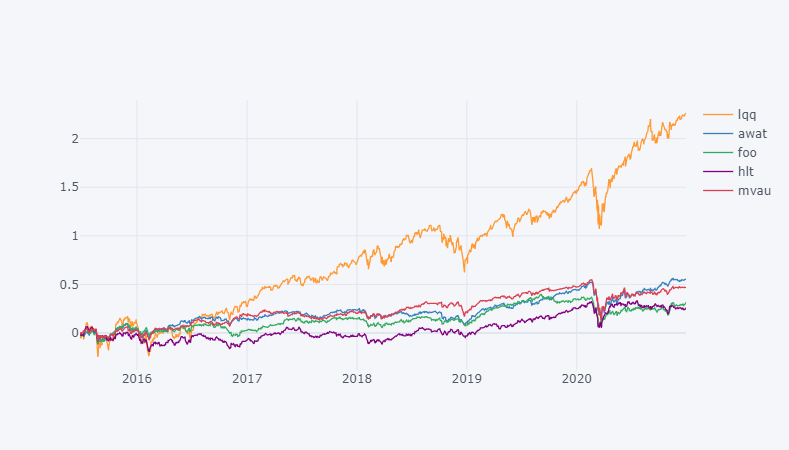

In [5]:
period_per_year, portfolio_comp_returns = get_clean_data(portfolio_raw_data, components='prices', period='daily')
portfolio_comp_returns.cumsum().iplot()

In [6]:
portfolio_comp_returns.head()

,lqq,awat,foo,hlt,mvau
DateTime,,,,,
2015-06-26,-0.008534,0.002463,0.002097,-0.001398,0.005690
2015-06-29,-0.047430,-0.019674,-0.019093,-0.017931,-0.018411
2015-06-30,0.008508,0.003881,-0.016096,-0.009642,0.002347
2015-07-01,0.018714,0.004838,0.015341,0.014145,0.013062
2015-07-02,0.001624,0.001556,-0.001205,0.001664,0.000377


### 3- Portfolio risk indicators and statistics

In [7]:
summary_stats(portfolio_comp_returns, period_per_year, risk_free_rate=0.02, VaR_method="modified", VaR_level=5).sort_values('Annualized return', ascending=False)

,Annualized return,Annualized volatility,Sharpe_ratio,VaR 5%,CVaR 5%,Max Drawdown
lqq,0.347507,0.446065,0.719860,0.044040,0.001214,-0.524475
awat,0.087248,0.170725,0.386199,0.016566,0.000750,-0.363135
mvau,0.066726,0.185165,0.247411,0.017753,0.000787,-0.369124
foo,0.044658,0.158950,0.152093,0.017154,0.000963,-0.298237
hlt,0.032226,0.169533,0.070701,0.018007,0.001249,-0.247622


### 4- Optimal components' weights of the portfolio according to a targeted return

Let's compute the covariance matrices (risk estimates) of the portfolio components:

In [8]:
risk_estimates = portfolio_comp_returns.cov()
risk_estimates.values

,lqq,awat,foo,hlt,mvau
lqq,0.000790,0.000212,0.000124,0.000136,0.000264
awat,0.000212,0.000116,0.000072,0.000072,0.000110
foo,0.000124,0.000072,0.000100,0.000082,0.000064
hlt,0.000136,0.000072,0.000082,0.000114,0.000062
mvau,0.000264,0.000110,0.000064,0.000062,0.000136


In [9]:
risk_estimates.tail()

,lqq,awat,foo,hlt,mvau
lqq,0.000790,0.000212,0.000124,0.000136,0.000264
awat,0.000212,0.000116,0.000072,0.000072,0.000110
foo,0.000124,0.000072,0.000100,0.000082,0.000064
hlt,0.000136,0.000072,0.000082,0.000114,0.000062
mvau,0.000264,0.000110,0.000064,0.000062,0.000136


#### Risk estimates matrice heatmap

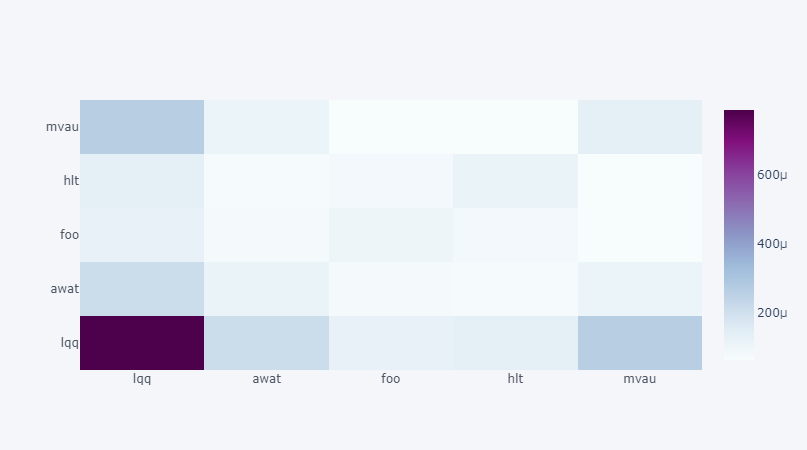

In [20]:
plot_risk_estimates_heatmap(risk_estimates, 'bupu')

In [102]:
#Let's compute the annualized  return of portfolio components
portfolio_comp_ann_returns = annualized_return(portfolio_comp_returns, period_per_year)
#Mean-Variance optimization object instanciation
portfolio = mvo(portfolio_comp_ann_returns, risk_estimates)
#Get the optimal weights according to the target return
target_return =0.15
weights = portfolio.efficient_risk(target_return)

In [103]:
weights

OrderedDict([('lqq', 0.29308691548033544),
             ('awat', 0.3893101987526484),
             ('foo', 0.317602885767016),
             ('hlt', 4.163336342344337e-17),
             ('mvau', 2.433898351958397e-16)])

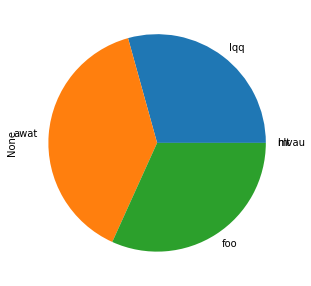

In [71]:
pd.Series(weights).plot.pie(figsize=(5,5))